In [ ]:
#load toy set data
# from sklearn import datasets
# iris = datasets.load_iris()

In [60]:
import math
import numpy as np
from scipy.spatial import distance
from sklearn.utils import shuffle

# NOTE(Abid): For debugging purposes only
from IPython.core.debugger import set_trace

def k_means(num_clusters, df, keyphrase_df, init_centres, pos_docs, neg_docs, neu_docs, must_link_penalty, cannot_link_penalty, keyphrase_penalty):

    #returns a list of k initial centre points for cluster initialization
    def choose_initial_centres(num_clusters, df):
        num_docs = len(df)
        every_x_item = num_docs/num_clusters
        df_centres = df[::math.ceil(every_x_item)]
        return df_centres.iloc[:num_clusters]

    #choose centre points from data if not already given
    if(len(init_centres)!=num_clusters):
        centres = []
        num_centres = math.floor(num_clusters/3)
        rem_centres = num_clusters%3
        pos_centers = choose_initial_centres(num_centres+rem_centres, pos_docs)
        neg_centers = choose_initial_centres(num_centres, neg_docs)
        neu_centres = choose_initial_centres(num_centres, neu_docs)
        centres = np.concatenate((pos_centers, neg_centers, neu_centres))
    
    #determine distance of points from the centres and assign clusters
    # df = shuffle(df)
    data = df.to_numpy()
    col_count = len(data[:][0])
    centroids = centres[:,:col_count-1]
    data = np.hstack([data, np.zeros((len(data),1)), np.ones((len(data),1))])
    #compute the centroids till the cluster assignment remains the same
    return fit(data, df, keyphrase_df, col_count, pos_docs, neg_docs, neu_docs, centroids, num_clusters, must_link_penalty, cannot_link_penalty, keyphrase_penalty)

def extract_sentiment_index(df, pos_docs, neg_docs,  neu_docs):
    pos_docs_loc = df.index.get_indexer(pos_docs.index.to_list())
    neg_docs_loc = df.index.get_indexer(neg_docs.index.to_list())
    neu_docs_loc = df.index.get_indexer(neu_docs.index.to_list())
    return pos_docs_loc, neg_docs_loc, neu_docs_loc

#takes in a dataframe and a center vector and outputs a series with distance values of all points from the vector
#last 2 columns reserved for cluster comparision (current cluster and prev cluster)
def fit(data, df, keyphrase_df, col_count, pos_docs, neg_docs, neu_docs, centroids, num_clusters, must_link_penalty, cannot_link_penalty, keyphrase_penalty):
    iter = 0
    pos_docs_loc, neg_docs_loc, neu_docs_loc = extract_sentiment_index(df, pos_docs, neg_docs, neu_docs)
    # print(data[:,col_count+1])
    # print(col_count)
    # print(data[:,:col_count+1])
    
    while(not np.array_equiv(data[:,col_count+1],data[:,col_count])):
        if(iter!=0):
            data[:,col_count] = data[:,col_count+1]
            data[:,col_count+1] = -1
            centroids = update_centroids(num_clusters, data[:,:col_count+1],col_count)
        iter+=1
        if(iter==4):
            break
        for row_index, point in enumerate(data):
            dist_val = []
            for index, center in enumerate(centroids):
                eucledian_dist = distance.euclidean(point[:col_count-1], center)
                penalty_dist = penalize(point, data, col_count, index, pos_docs_loc, neg_docs_loc, must_link_penalty, cannot_link_penalty)
                penalty_keyphrase = penalize_keyphrase(df, data, keyphrase_df, col_count, row_index, index, keyphrase_penalty)
                dist_val.append(eucledian_dist+penalty_dist+penalty_keyphrase)
            cluster_val = dist_val.index(min(dist_val))
            data[row_index,col_count+1] = cluster_val
        print('iteration count--->',iter)
    return data
    # pd.DataFrame(data).to_csv('./sentiment_clusters.csv')

# penalize point for not being assigned to must link peers and being assigned to cannot link peers:
def penalize(point, data, col_count, assumed_pt_cluster, pos_docs_loc, neg_docs_loc, must_link_penalty, cannot_link_penalty):
    
    penalty = 0.0

    #return zero penalty for neutral sentiment documents
    if point[col_count-1] == 0:
        return penalty
        
    elif point[col_count-1] == 1:
        must_link_set = pos_docs_loc
        cannot_link_set = neg_docs_loc
    
    else:
        must_link_set = neg_docs_loc
        cannot_link_set = pos_docs_loc
    
    #return negative penalty for neutral sentiment documents
    for ml_pt in must_link_set:
        if np.any(np.not_equal(data[ml_pt][:col_count-1],point[:col_count-1])) and data[ml_pt][col_count+1] != -1 and assumed_pt_cluster == data[ml_pt][col_count+1]:
            penalty += must_link_penalty

    #return positive penalty for  sentiment documents
    for cl_pt in cannot_link_set:
        if np.any(np.not_equal(data[cl_pt][:col_count-1],point[:col_count-1])) and data[cl_pt][col_count+1] != -1 and assumed_pt_cluster == data[cl_pt][col_count+1]:
            penalty += cannot_link_penalty

    return penalty

# NOTE(Abid): I've decided to not give negative penalty if the keyphrases do not much, based on the reasoning that a cluster will 
#             almost always have more topics that are different from the point than those that are similar to it.
def penalize_keyphrase(df, data, keyphrase_df, col_count, point_idx, potential_cluster_val, penalty_vals):
    penalty = 0.0
    
    point_keyphrases = (keyphrase_df.iloc[point_idx,:]).to_numpy()
    for idx in range(len(data[:,0])):
        test_point = df.iloc[idx,:]
        if point_idx == idx:
            continue
        
        if data[idx, col_count+1] != -1 and data[idx, col_count+1] == potential_cluster_val:
            test_keyphrases = np.array([str(keyphrase_df.iloc[idx,0]), str(keyphrase_df.iloc[idx,2])])
            test_weights = np.array([float(keyphrase_df.iloc[idx,1]), float(keyphrase_df.iloc[idx,3])])
            keyphrases = np.array([point_keyphrases[0], point_keyphrases[2]])
            weights = np.array([point_keyphrases[1], point_keyphrases[3]])
            for pen_idx in range(len(penalty_vals)):
                keyphrase = keyphrases[pen_idx]
                weight = weights[pen_idx]
                first_word = keyphrase.split(" ")[0]
                if first_word == "<None>" or len(first_word) == 0:
                    return penalty
                if first_word == test_keyphrases[0].split(" ")[0]:
#                     set_trace()
                    penalty -= ((weight+test_weights[0])/2) * penalty_vals[pen_idx]
                elif first_word == test_keyphrases[1].split(" ")[0]:
                    penalty -= ((weight+test_weights[1])/2) * penalty_vals[pen_idx]
#                 else:
#                     penalty -= 0.5((weight+test_weights[pen_idx])/2) * penalty_vals[pen_idx]
    return penalty

#handles case where no point is assigned to a cluster center
def update_centroids(num_clusters, data, col_count):
    
    centroids = []
    data_per_cluster = []
    for clus_no in range(num_clusters):
        data_per_cluster.append(data[data[:,col_count]== float(clus_no)])
    
    for cluster_data in data_per_cluster:
        centroids.append(np.mean(cluster_data[:,:col_count-1], axis=0))
    
    return centroids

In [61]:
#load data in dataframes
import pandas as pd
doc_path = "../feature_extraction/word2vec_LDA_sentiment.csv"
df=pd.read_csv(doc_path,index_col='docno')
df = df.iloc[:150,:]

keyphrase_df = pd.read_csv("keyphrase_docno_added.csv",index_col='docno')
# print(df.shape)
pos_doc_df = df[df["class"] == 1]
neg_doc_df = df[df["class"] == -1]
neu_doc_df = df[df["class"] == 0]
cluster_num = 5
keyphrase_penalty = np.array([10, 4])
clustered_data = k_means(cluster_num, df, keyphrase_df, [], pos_doc_df, neg_doc_df, neu_doc_df, -0.2, 0.4, keyphrase_penalty)

iteration count---> 1
iteration count---> 2
iteration count---> 3


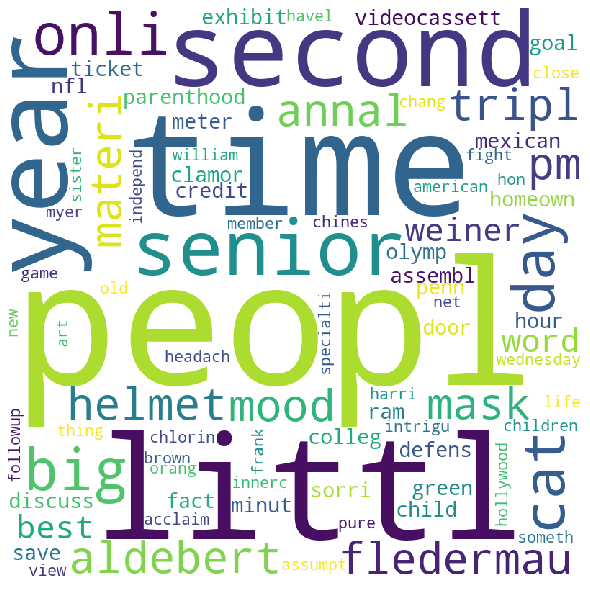

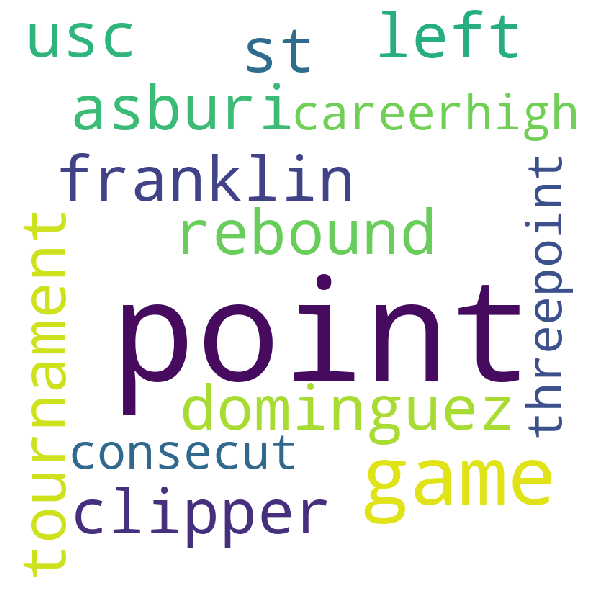

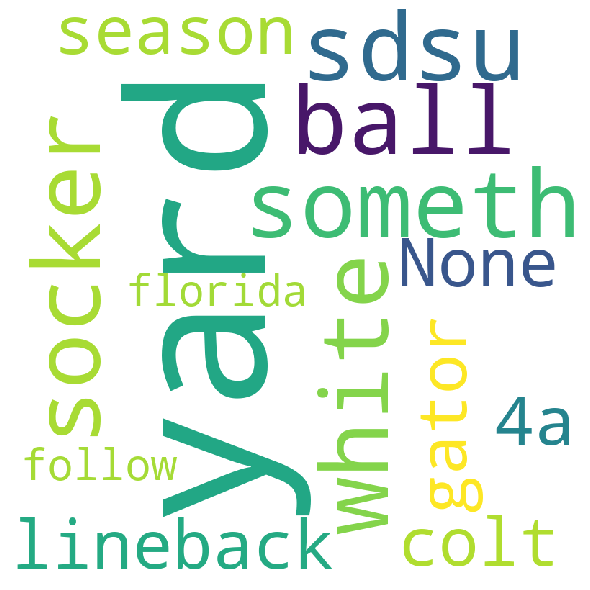

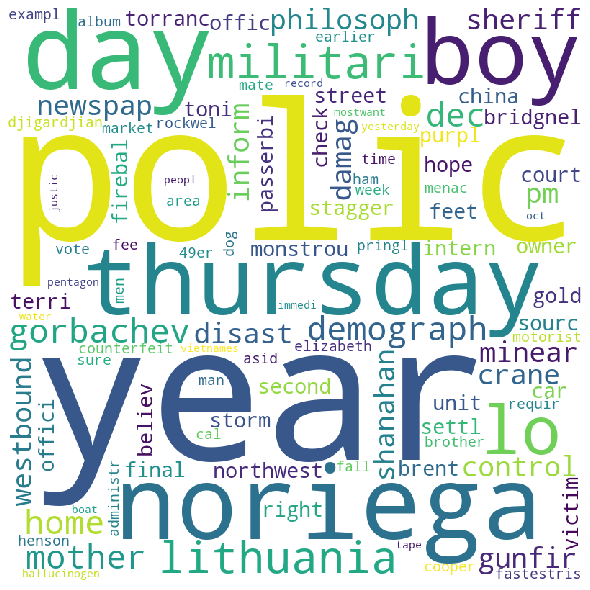

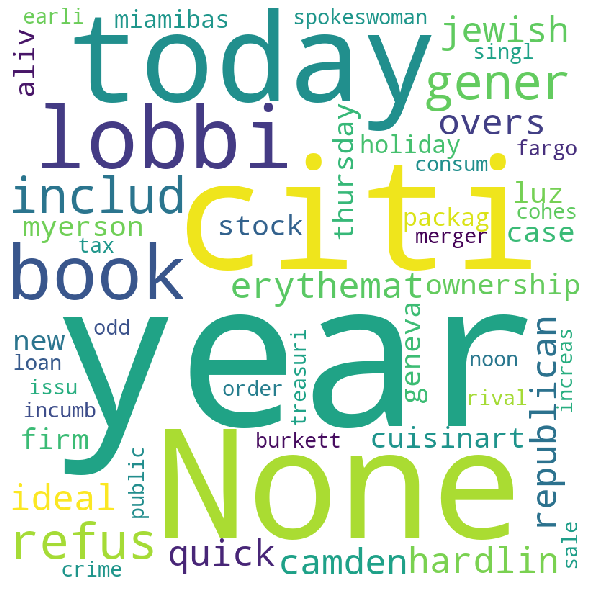

In [46]:
clustered_data.shape[0]

150

In [48]:
%pip install wordcloud

     -------------------------------------- 154.6/154.6 kB 2.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
